In [358]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [359]:
# Reading from files
# in the order of [imA, imB, imC, imD] 
names = ['A', 'B', 'C', 'D']
obs_position = [(1.066,0.323), (0.,0.), (0.721,1.159), (-0.157,1.021)]
obs_posx = [1.066, 0., 0.721, -0.157]
obs_posy = [0.323, 0., 1.159, 1.021]
position_err = [0.01, 0.01, 0.01, 0.01]
obs_flux = [1.0, 0.65, 1.25, 1.17]
flux_err = [0.04, 0.04, 0.03, 0.04]
color = ['g', 'r', 'b', 'y']

LENS = "sie"
CONSTRAINT = "mcmc2"

result = pd.read_csv('../'+LENS+'/out_point_'+CONSTRAINT+'.dat', sep='\s+', skiprows=1, header=None, names=['pos_x', 'pos_y', 'mag', 'timedelay'])
result = pd.DataFrame(result)

# Sort order of Images
tol = 0.2
order = []
for _, img in result.iterrows():
    for i in range(4):
        x, y = obs_position[i]
        if abs(img["pos_x"]-x) <= tol and abs(img["pos_y"]-y) <= tol: 
            order.append(names[i])
if len(order) == 4:
    result["Image"] = order
    result = result.sort_values(by="Image")
else:
    print("Unable to distinguish images by predicted position")

In [360]:
result

,pos_x,pos_y,mag,timedelay,Image
1,1.0115,0.2195,10.8319,0.000,A
0,0.0040,-0.0079,-9.4860,1.180,B
3,0.6998,1.1649,-10.4505,1.004,C
2,-0.2148,0.9545,11.9039,0.199,D


In [361]:
# Position offset calculation
predicted_posx = list(result["pos_x"])
predicted_posy = list(result["pos_y"])
pos_offset = [((obs_posx[i]-predicted_posx[i])**2 + (obs_posy[i]-predicted_posy[i])**2)**0.5 for i in range(4)]
rms_pos = np.mean([(obs_posx[i]-predicted_posx[i])**2 + (obs_posy[i]-predicted_posy[i])**2 for i in range(4)])**0.5 

# Flux offset 
magnification = list(result["mag"])
PFR= [np.abs(magnification[i]/magnification[0]) for i in range(4)]
flux_offset = [np.abs(obs_flux[i] - PFR[i]) for i in range(4)]
rms_flux = np.mean([((obs_flux[i] - PFR[i]))**2 for i in range(4)])**0.5
rms_pos

0.07417588893973565

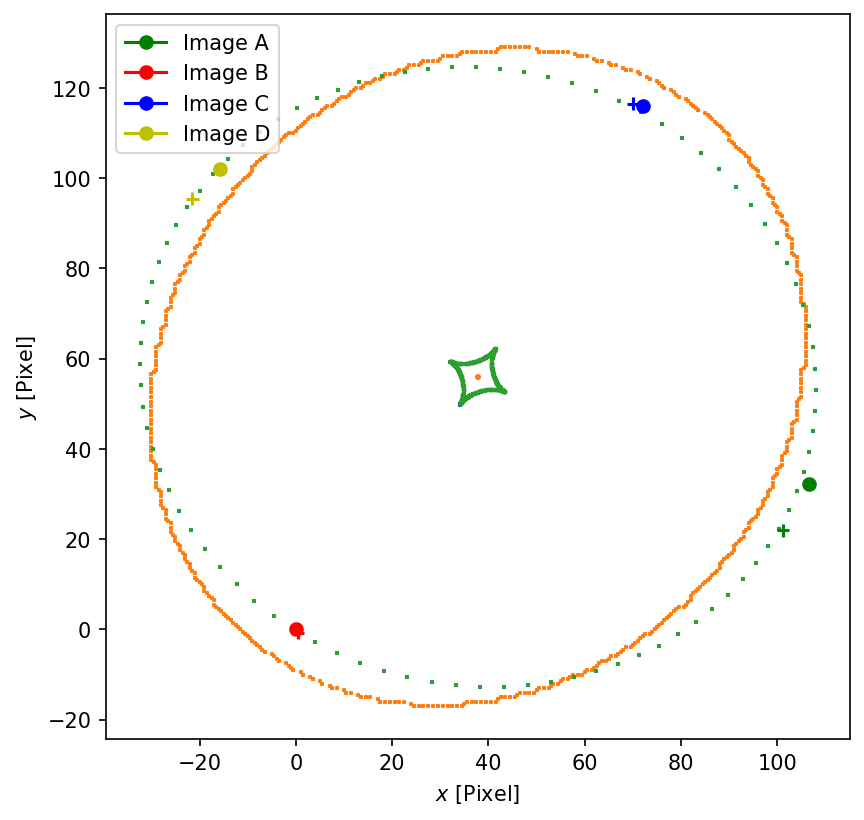

In [362]:
# Plotting curves
caus = pd.read_csv('../'+LENS+'/out_crit_'+CONSTRAINT+'.dat',sep='\s+',header=None)
caus = pd.DataFrame(caus)
n=0.01

x1,y1 = 0, 0 ## Center of the obs image


def center_corr(x,y):
    pix_size = n ## Pixel size of the obs image
    x0,y0 = x1,y1 ## Center of the obs image

    x_prime=x/pix_size+x0
    y_prime=y/pix_size+y0
    return x_prime,y_prime

xs1,ys1 = center_corr(caus[2],caus[3])  ## Caustics
xs2,ys2 = center_corr(caus[6],caus[7])  ## Caustics
xc1,yc1 = center_corr(caus[0],caus[1])  ## Crit Curve
xc2,yc2 = center_corr(caus[4],caus[5])  ## Crit Curve


plt.figure(figsize = (6.4, 6.4),facecolor='white',dpi=150)

ax = plt.subplot(1,1,1)
ax.scatter(xs1,ys1,marker=',',s=1)
ax.scatter(xc1,yc1,marker=',',s=1)
ax.scatter(xs2,ys2,marker=',',s=1)
plt.xlabel('$x$ [Pixel]')
plt.ylabel('$y$ [Pixel]')

# predicted position in cross
plt.scatter(result["pos_x"]/n, result["pos_y"]/n, marker='+', color=color)

a=0
b=0

# observed position
plt.plot((1.066-a)/n, (0.323-b)/n, 'g', marker='o', label="Image A")
plt.plot((0.-a)/n, (0.-b)/n, 'r', marker='o', label="Image B")
plt.plot((0.721-a)/n, (1.159-b)/n, 'b', marker='o', label="Image C")
plt.plot((-0.157-a)/n, (1.021-b)/n, 'y', marker='o', label="Image D")


plt.legend()
plt.savefig(f"../fig/caus_{LENS}_{CONSTRAINT}", bbox_inches='tight', dpi = 300)
plt.show()


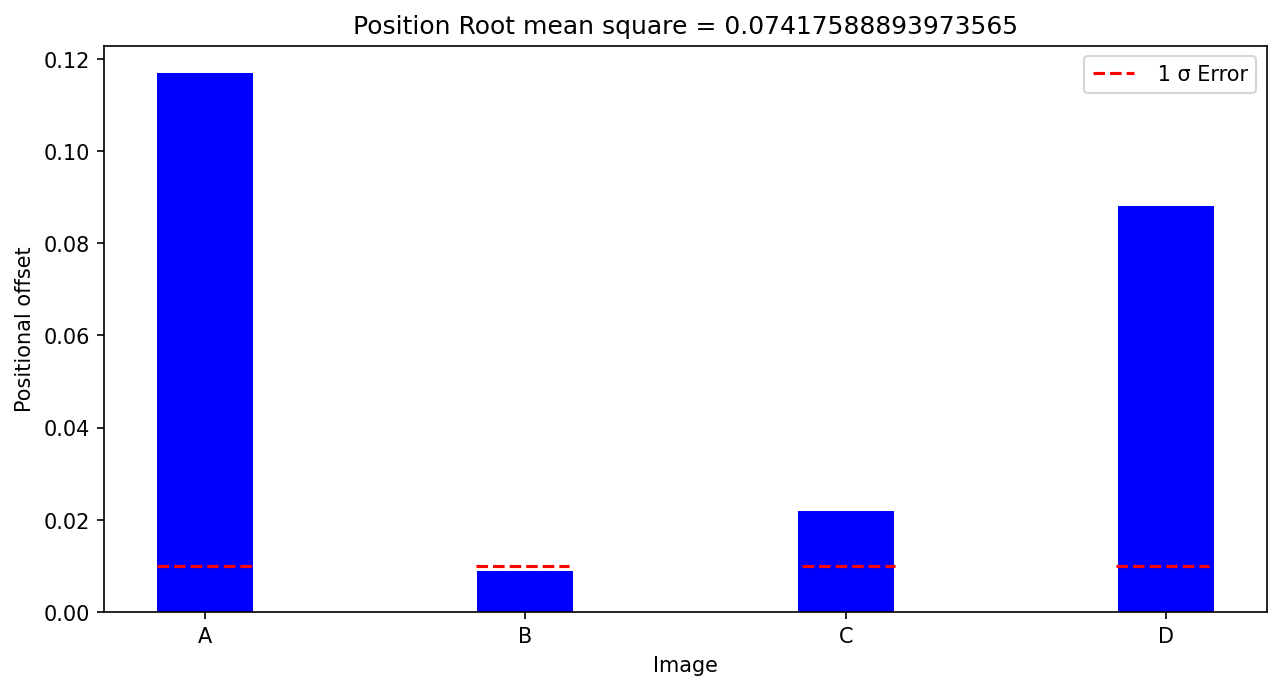

In [363]:
# Position offset plot

  
fig = plt.figure(figsize = (10, 5), facecolor='white', dpi=150)

# creating the bar plot
plt.bar(names, pos_offset, color ='b',
        width = 0.3)

plt.axhline(y = 0.01,xmin =0.045, xmax =0.13, color = 'r', linestyle = 'dashed', label = " 1 σ Error")
plt.axhline(y = 0.01,xmin =0.32, xmax =0.4, color = 'r', linestyle = 'dashed')
plt.axhline(y = 0.01,xmin =0.6, xmax =0.68, color = 'r', linestyle = 'dashed')
plt.axhline(y = 0.01,xmin =0.87, xmax =0.95, color = 'r', linestyle = 'dashed')
plt.legend(loc = 'upper right')

# max_y_value = 0.03*3
# plt.ylim(0, max_y_value)

plt.xlabel("Image")
plt.ylabel("Positional offset")
plt.title(f"Position Root mean square = {rms_pos}")
plt.savefig(f"../fig/pos_offset_{LENS}_{CONSTRAINT}", dpi=300)
plt.show()

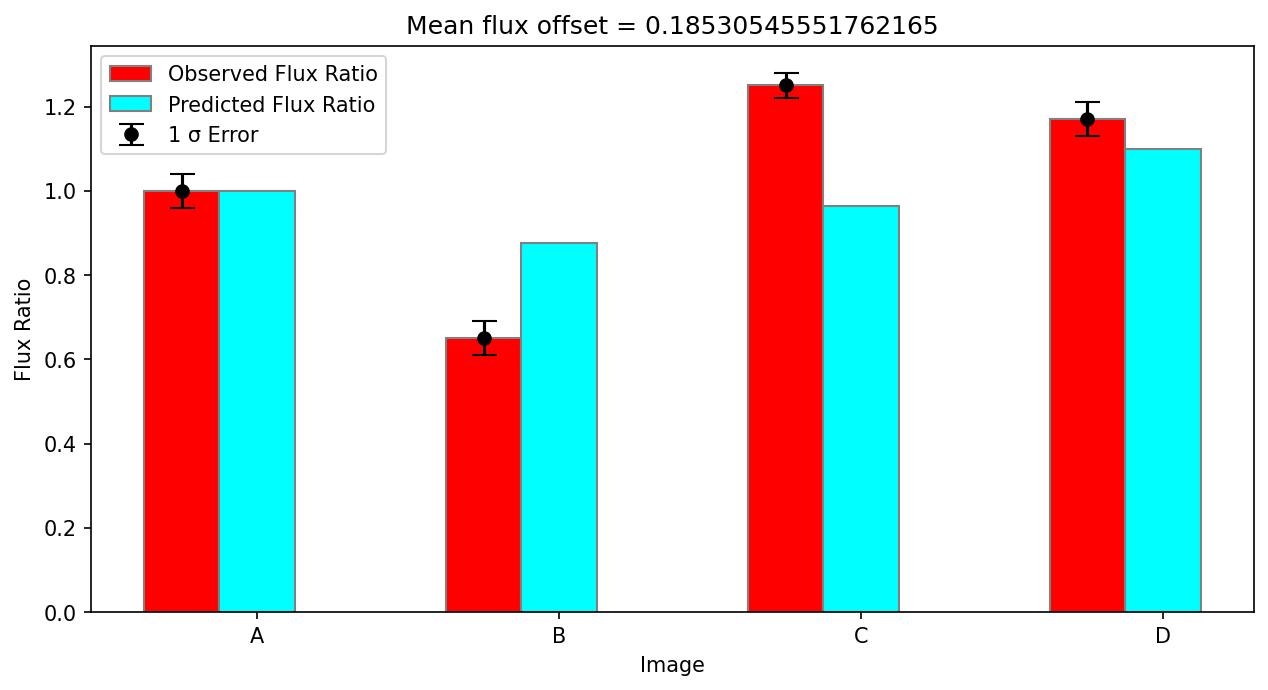

In [364]:
# Plot Flux offset
# Set width of bar
barWidth = 0.25
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white', dpi=150)


# Set position of bar on X axis
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]

# Make the plot
ax.bar(br1, obs_flux, color='red', width=barWidth, edgecolor='grey', label='Observed Flux Ratio')
ax.bar(br2, PFR, color='cyan', width=barWidth, edgecolor='grey', label='Predicted Flux Ratio')


# Add error bars
ax.errorbar(br1, obs_flux, yerr=flux_err, fmt='o', color='black', capsize=6, label='1 σ Error')

# Adding Xticks
plt.xlabel('Image')
plt.ylabel('Flux Ratio')
plt.xticks([r + barWidth for r in range(len(obs_flux))], names)
plt.title(f"Mean flux offset = {rms_flux}")

# Add legend
plt.legend()

# Show the plot
plt.savefig(f"../fig/flux_offset_{LENS}_{CONSTRAINT}", dpi=300)
plt.show()